ANÁLISE EXPLORATÓRIA: COMPORTAMENTOS DE CLIENTES E SEGMENTOS

IMPORTS

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sea
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#StandardScaler (do sklearn.preprocessing):

#Serve para padronizar os dados (colocar tudo na mesma escala com média 0 e desvio padrão 1). Isso é essencial para algoritmos como o KMeans, que são sensíveis a escalas diferentes.

#KMeans (do sklearn.cluster):

#É um algoritmo de clusterização que agrupa dados em k grupos com base em semelhanças. Aqui, ele agrupou os clientes com base em recência, frequência e valor.

DATA FRAME

In [3]:
df = pd.read_excel("../Proj2.xlsx")

INFORMAÇÕES QUE DESEJAMOS CONSEGUIR NESSA ETAPA:

Qual segmento (Consumidor, Corporativo, Home Office) gera:

    Mais receita

    Maior ticket médio

    Maior margem média

Top clientes:

    Valor total

    Frequência de pedidos

    Ideal para pensar em fidelização ou VIPs

Agrupar clientes em clusters:

    Recente e frequente “Clientes VIP”

    Pouco recente, alta frequência  “Potencial churn”

    Baixa frequência e valor “Clientes novos ou fracos”

TÓPICO 1:

In [4]:
segmentos = df.groupby('segmento').agg({
    'vendas': 'sum',
    'lucro': 'sum',
    'id_pedido': 'nunique'
}).reset_index()

segmentos['ticket_medio'] = segmentos['vendas'] / segmentos['id_pedido']
segmentos['margem'] = segmentos['lucro'] / segmentos['vendas']

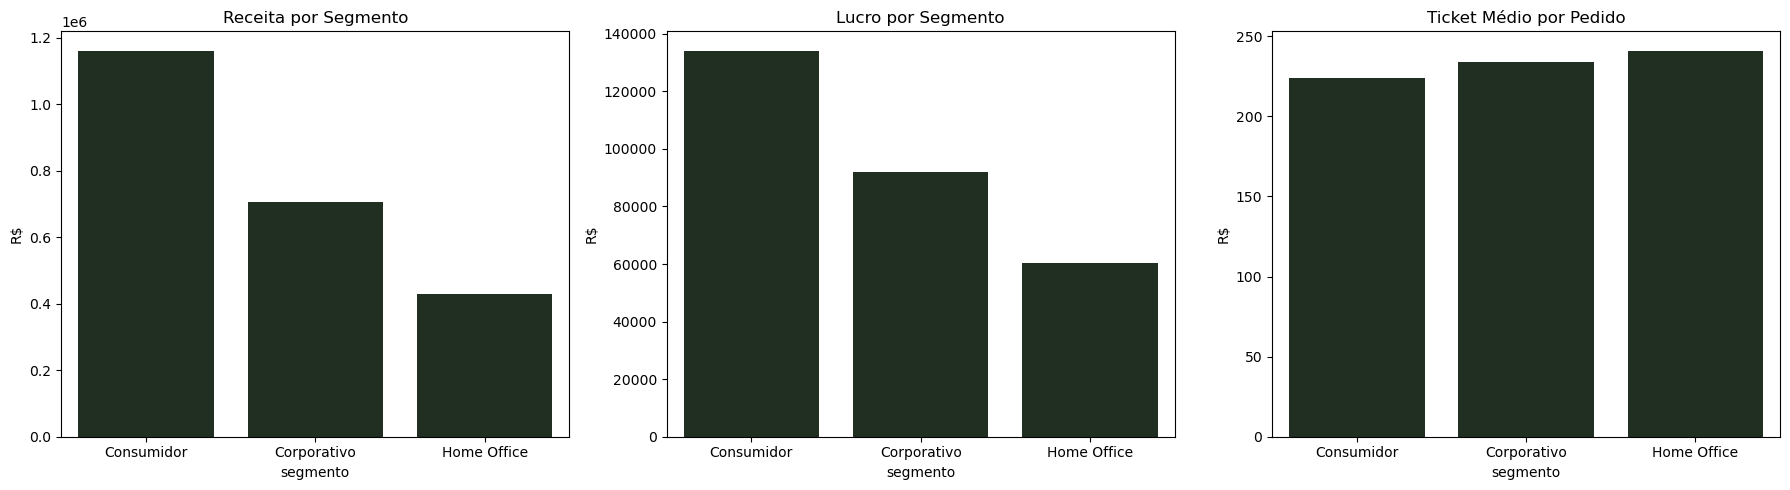

In [5]:
verde_escuro = '#1D311F'

fig, axs = plt.subplots(1, 3, figsize=(18,5))

# Receita
sea.barplot(x='segmento', y='vendas', data=segmentos, ax=axs[0], color=verde_escuro)
axs[0].set_title('Receita por Segmento')
axs[0].set_ylabel('R$')

# Lucro
sea.barplot(x='segmento', y='lucro', data=segmentos, ax=axs[1], color=verde_escuro)
axs[1].set_title('Lucro por Segmento')
axs[1].set_ylabel('R$')

# Ticket Médio
sea.barplot(x='segmento', y='ticket_medio', data=segmentos, ax=axs[2], color=verde_escuro)
axs[2].set_title('Ticket Médio por Pedido')
axs[2].set_ylabel('R$')

plt.tight_layout()
plt.show()

Com esses gráficos fica claro que o consumiddor lidera em receita e lucro mesmo possuindo o menor ticket médio. Por outro lado o Home Office mesmo tendo a menor receita e lucro oferece o maior ticket médio. Dessa forma, talvez um maior marketing focado nesse segmento pudesse ser uma boa escolha, já que com um ticket médio alto, se o número de pedidos aumentasse, impactaria diretamente no lucro e na receita

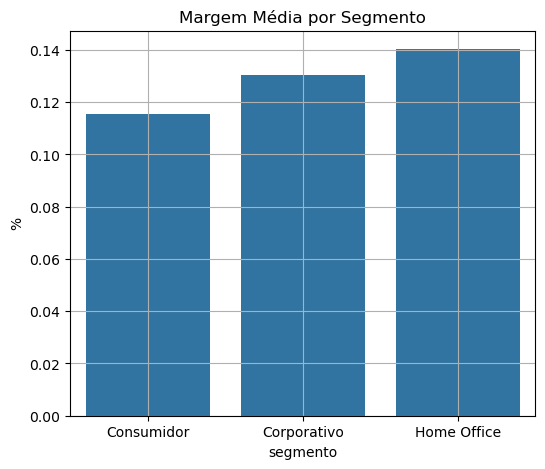

In [6]:
plt.figure(figsize=(6,5))
sea.barplot(x='segmento', y='margem', data=segmentos)
plt.title('Margem Média por Segmento')
plt.ylabel('%')
plt.grid(True)
plt.show()



- O segmento Consumidor lidera em volume de vendas e lucro absoluto, porém apresenta o menor ticket médio por pedido e a menor margem média, o que indica menor eficiência financeira por venda.
- Já o segmento Home Office, apesar de ter menor volume de vendas, possui o maior ticket médio e a melhor margem, o que o torna altamente rentável por pedido.
- O segmento Corporativo fica em uma posição intermediária, equilibrando bem volume e rentabilidade.

Esses dados indicam que estratégias como campanhas promocionais, upsell e fidelização podem ser segmentadas com mais inteligência, priorizando margens em vez de apenas volume.


TÓPICO 2:

In [7]:
top_clientes = df.groupby('nome_cliente').agg({
    'vendas': 'sum',
    'id_pedido': 'nunique'
}).rename(columns={
    'vendas': 'total_gasto',
    'id_pedido': 'qtd_pedidos'
}).sort_values(by='total_gasto', ascending=False).head(10)

top_clientes

,total_gasto,qtd_pedidos
nome_cliente,,
Harold Dahlen,36521.6425,36
Clytie Kelty,26791.6070,24
Karl Brown,24383.7630,37
Ed Braxton,22441.4620,46
Christy Brittain,18250.8500,30
Joe Elijah,17862.3020,12
Scott Cohen,15587.1690,16
Giulietta Dortch,15052.4260,32
Bill Eplett,15027.7620,24


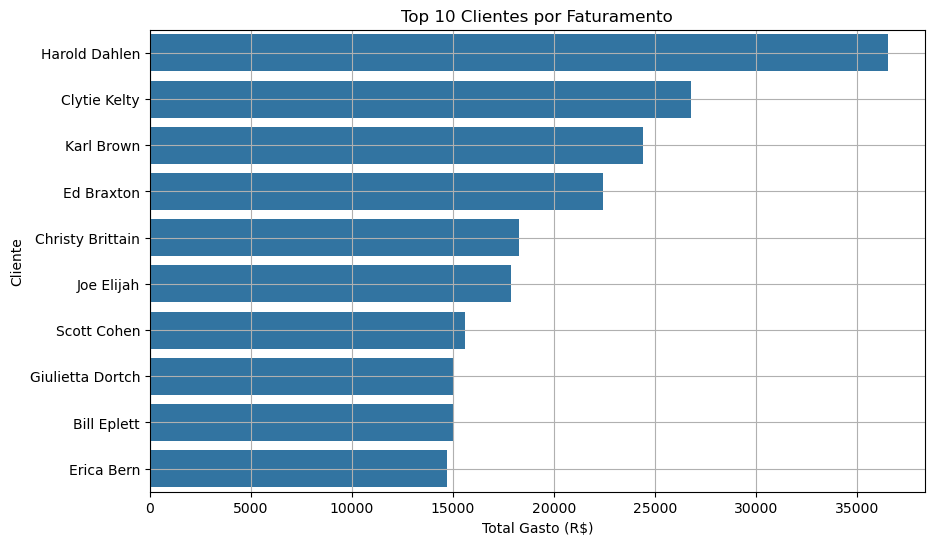

In [8]:
plt.figure(figsize=(10,6))
sea.barplot(x=top_clientes['total_gasto'], y=top_clientes.index)
plt.title('Top 10 Clientes por Faturamento')
plt.xlabel('Total Gasto (R$)')
plt.ylabel('Cliente')
plt.grid(True)
plt.show()

Nada de muito importante a se considerar, porém é importante ressaltar que apenas um cliente gastou mais de 35mil reais, sendo disparado o cliente que mais gastou na empresa, sendo um caso claramente a parte.

In [9]:
top_frequencia = df.groupby('nome_cliente')['id_pedido'].nunique().reset_index()
top_frequencia = top_frequencia.rename(columns={'id_pedido': 'qtd_pedidos'})
top_frequencia = top_frequencia.sort_values(by='qtd_pedidos', ascending=False).head(10)


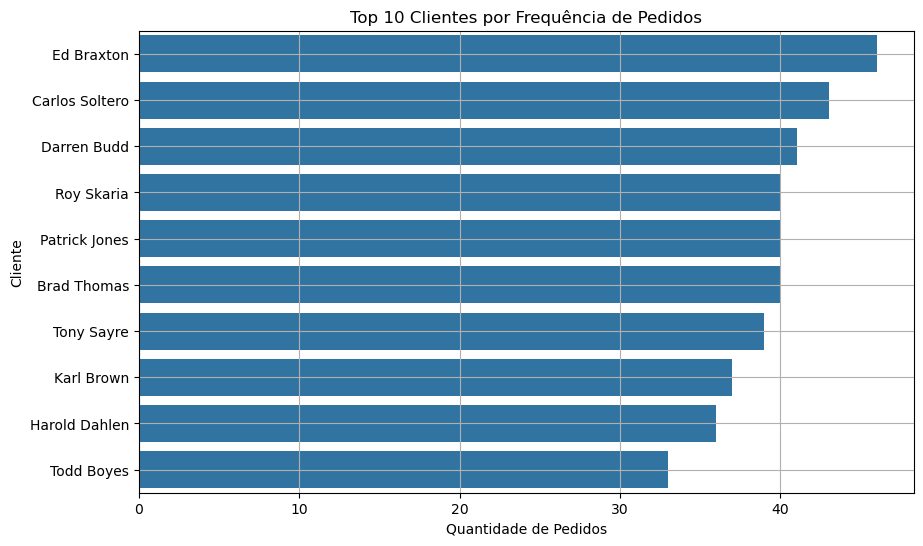

In [10]:
plt.figure(figsize=(10,6))
sea.barplot(x='qtd_pedidos', y='nome_cliente', data=top_frequencia)
plt.title('Top 10 Clientes por Frequência de Pedidos')
plt.xlabel('Quantidade de Pedidos')
plt.ylabel('Cliente')
plt.grid(True)
plt.show()

Nada muito fora do esperado no gráfico, talvez seja interessante ressaltar que o Harold(cliente que mais gastou) também se encontra entre os que mais pediu, porém não está nem nos top5, talvez indicando q ele faça menos pedidos, porém mais caros.

TÓPICO 3:

c:\Users\joaoh\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\joaoh\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\joaoh\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joaoh\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\joaoh\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi

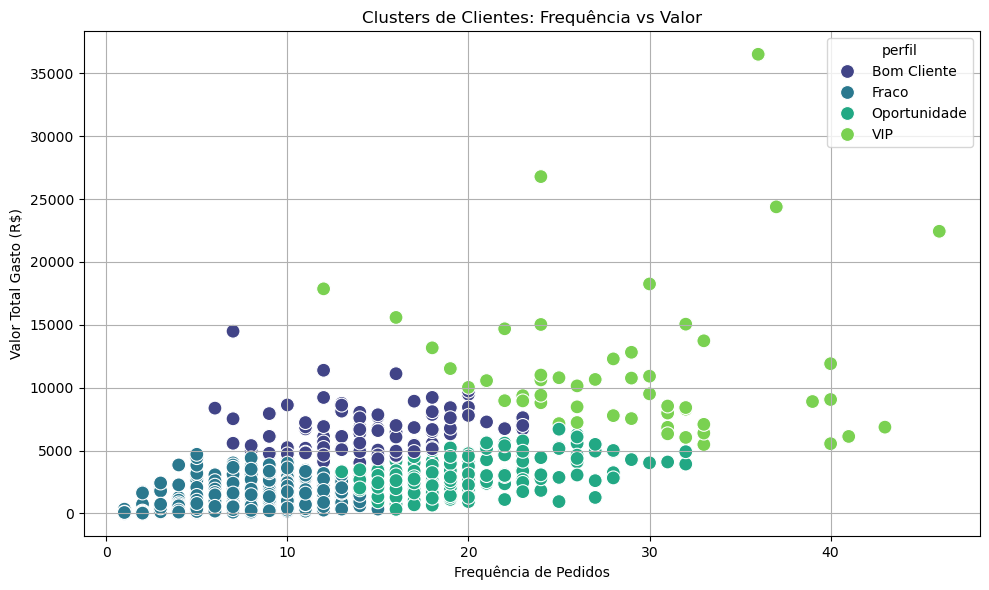

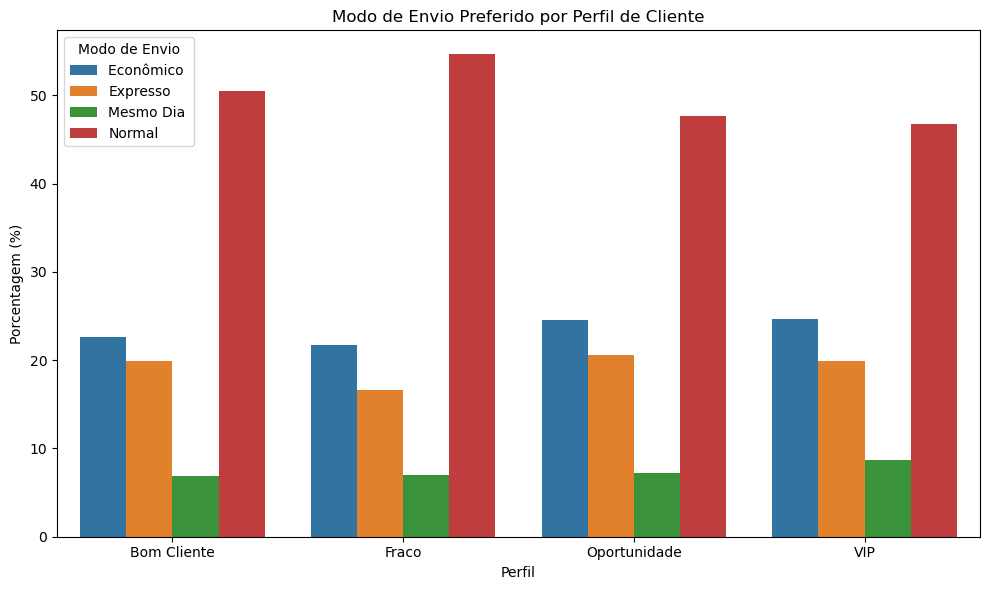

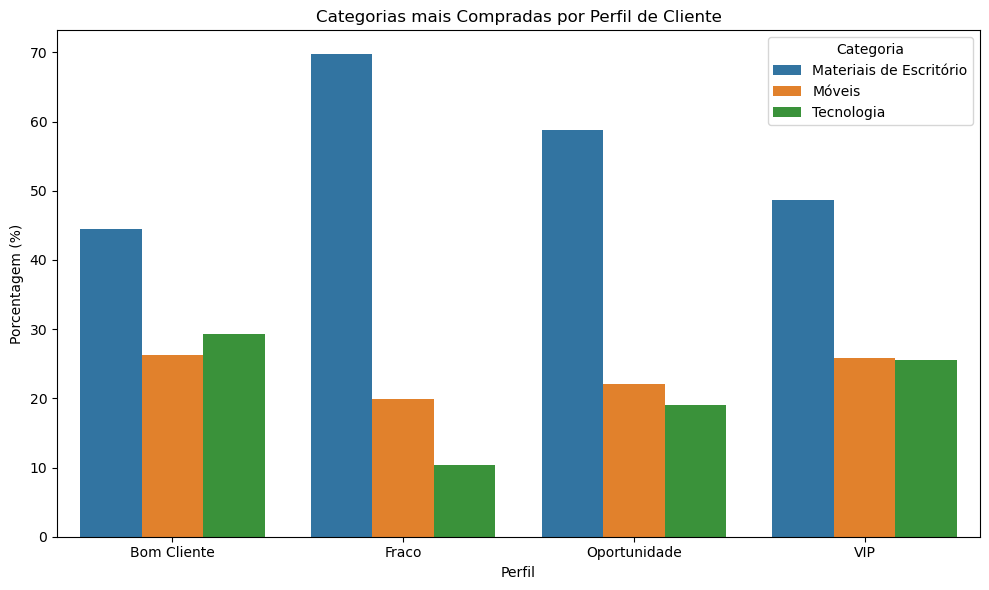

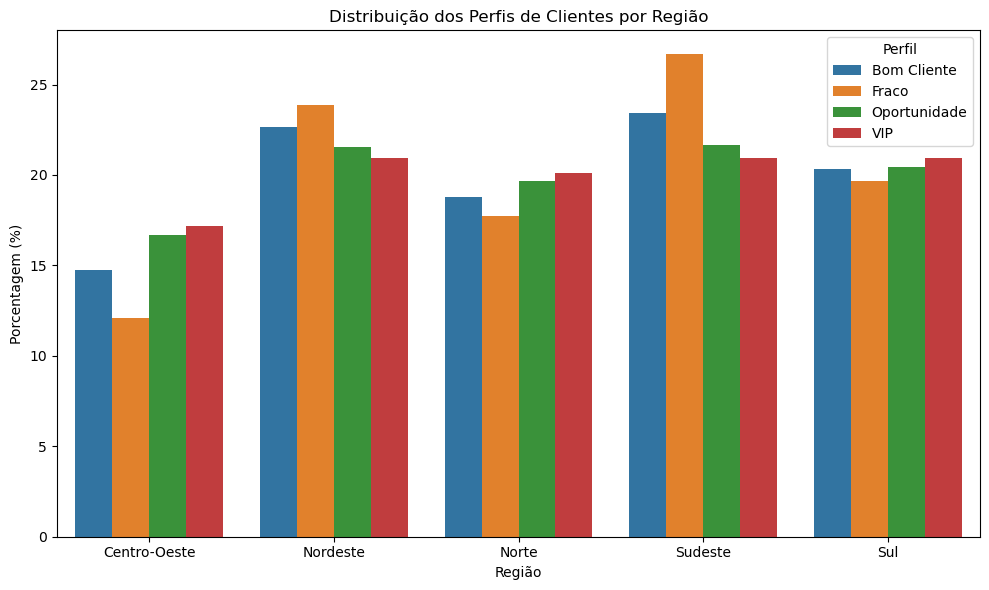

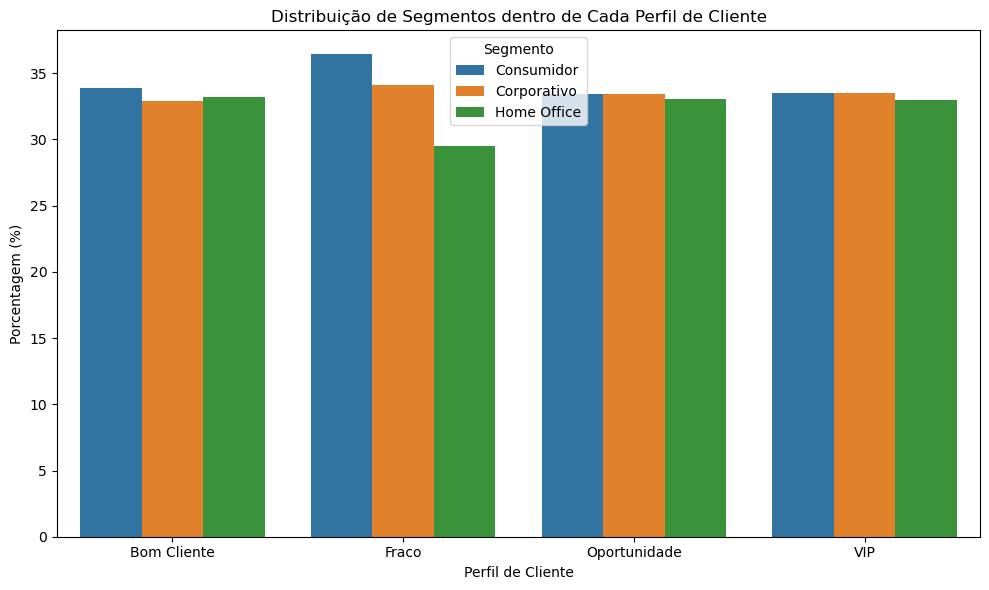

In [11]:

rfm = df.groupby('nome_cliente').agg({
    'id_pedido': 'nunique',   # frequência
    'vendas': 'sum'           # valor
}).reset_index()

rfm.columns = ['cliente', 'frequencia', 'valor']

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['frequencia', 'valor']])

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

def rotulo_cluster(linha):
    if linha['cluster'] == 1:
        return 'VIP'
    elif linha['cluster'] == 2:
        return 'Bom Cliente'
    elif linha['cluster'] == 3:
        return 'Oportunidade'
    else:
        return 'Fraco'

rfm['perfil'] = rfm.apply(rotulo_cluster, axis=1)


plt.figure(figsize=(10,6))
sea.scatterplot(
    data=rfm,
    x='frequencia',
    y='valor',
    hue='perfil',
    palette='viridis',
    s=100
)
plt.title('Clusters de Clientes: Frequência vs Valor')
plt.xlabel('Frequência de Pedidos')
plt.ylabel('Valor Total Gasto (R$)')
plt.grid(True)
plt.tight_layout()
plt.show()

dados_extra = df[['nome_cliente', 'modo_envio', 'categoria', 'subcategoria']].drop_duplicates()
rfm = rfm.merge(dados_extra, left_on='cliente', right_on='nome_cliente', how='left')
rfm.drop(columns=['nome_cliente'], inplace=True)  # limpar duplicada

modo_envio_por_perfil = rfm.groupby(['perfil', 'modo_envio']).size().reset_index(name='quantidade')
modo_envio_por_perfil['%'] = modo_envio_por_perfil.groupby('perfil')['quantidade'].transform(lambda x: (x / x.sum() * 100).round(2))

plt.figure(figsize=(10,6))
sea.barplot(data=modo_envio_por_perfil, x='perfil', y='%', hue='modo_envio')
plt.title('Modo de Envio Preferido por Perfil de Cliente')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Perfil')
plt.legend(title='Modo de Envio')
plt.tight_layout()
plt.show()

categoria_por_perfil = rfm.groupby(['perfil', 'categoria']).size().reset_index(name='quantidade')
categoria_por_perfil['%'] = categoria_por_perfil.groupby('perfil')['quantidade'].transform(lambda x: (x / x.sum() * 100).round(2))

plt.figure(figsize=(10,6))
sea.barplot(data=categoria_por_perfil, x='perfil', y='%', hue='categoria')
plt.title('Categorias mais Compradas por Perfil de Cliente')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Perfil')
plt.legend(title='Categoria')
plt.tight_layout()
plt.show()

clientes_regioes = df[['nome_cliente', 'região']].drop_duplicates()
rfm_geo = rfm.merge(clientes_regioes, left_on='cliente', right_on='nome_cliente', how='left')

contagem_regioes = rfm_geo.groupby(['perfil', 'região']).size().reset_index(name='quantidade')

contagem_regioes['percentual'] = contagem_regioes.groupby('perfil')['quantidade'].transform(lambda x: (x / x.sum()) * 100)


plt.figure(figsize=(10,6))
sea.barplot(data=contagem_regioes, x='região', y='percentual', hue='perfil')
plt.title('Distribuição dos Perfis de Clientes por Região')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Região')
plt.legend(title='Perfil')
plt.tight_layout()
plt.show()

rfm = rfm.merge(
    df[['nome_cliente', 'segmento']].drop_duplicates(),
    left_on='cliente',
    right_on='nome_cliente',
    how='left'
)

rfm.drop(columns=['nome_cliente'], inplace=True)

segmento_por_perfil = rfm.groupby(['perfil', 'segmento']).size().reset_index(name='contagem')

total_por_perfil = segmento_por_perfil.groupby('perfil')['contagem'].transform('sum')

segmento_por_perfil['porcentagem'] = (segmento_por_perfil['contagem'] / total_por_perfil * 100).round(2)

plt.figure(figsize=(10, 6))
sea.barplot(
    data=segmento_por_perfil,
    x='perfil',
    y='porcentagem',
    hue='segmento'
)
plt.title('Distribuição de Segmentos dentro de Cada Perfil de Cliente')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Perfil de Cliente')
plt.legend(title='Segmento')
plt.tight_layout()
plt.show()




Clientes VIP estão concentrados no canto superior direito, logo eles compram com frequência e gastam muito, dessa forma devem ser priorizados em programas de fidelidade, atendimento diferenciado e retenção.

Clientes Fracos estão no canto inferior esquerdo: baixa frequência e baixo valor, logo podem ser clientes ocasionais, desengajados ou novos, e talvez precisem de campanhas específicas.

Oportunidades fazem muitos pedidos, mas gastam pouco, logo  vale a pena analisar o tipo de produto que compram e tentar estratégias para aumentar o ticket médio.

Bons Clientes gastam bem, mesmo que não comprem com tanta frequência, logo podem ser impactados com campanhas de reativação ou engajamento.

Em busca de aprofundar a clusterização, buscamos através desses gráficos plotados após o o primerio gráfico, ver algum indício ou correlacionametno entre alguns cluster. Dado os gráficos, os cluster mostram características muito parecidas nos campos: Modo de envio preferido, Categorias mais compradas, distribuição das regiões e distribuição de segmento.

TENTATIVA DE MODELO DE CLASSIFICAÇÃO SE É LUCRATIVO OU NÃO A PARTIR DE DESCONTO, PREÇO POR UNIDADE(VENDAS/QUANTIDADE), QUANTIDADE E SUBCATEGORIA

In [12]:
print(df.columns)

Index(['id_pedido', 'nome_cliente', 'modo_envio', 'estado', 'vendas',
       'quantidade', 'desconto', 'lucro', 'segmento', 'região', 'subcategoria',
       'categoria', 'dia_pedido', 'dia_semana_pedido', 'mes_pedido',
       'ano_pedido', 'dia_envio', 'mes_envio', 'ano_envio', 'data_pedido',
       'mes_ano', 'tempo_preparacao'],
      dtype='object')


              precision    recall  f1-score   support

           0       0.97      0.63      0.76       591
           1       0.92      1.00      0.95      2408

    accuracy                           0.92      2999
   macro avg       0.95      0.81      0.86      2999
weighted avg       0.93      0.92      0.92      2999

AUC da Curva ROC: 0.95


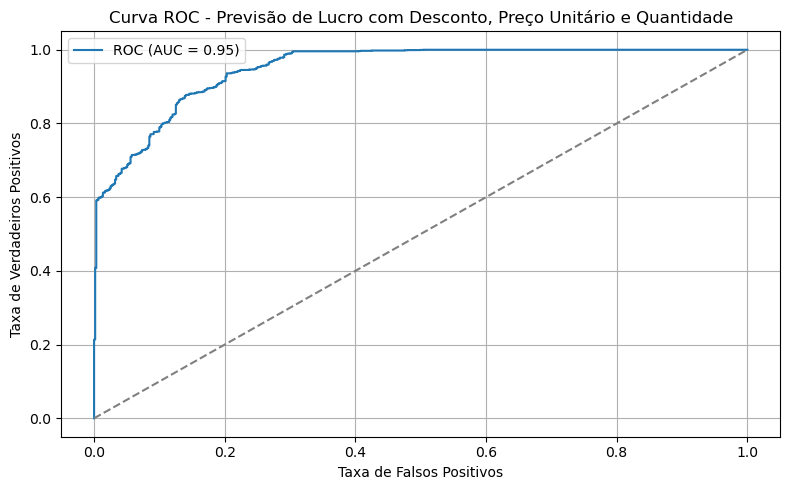

Importância das Variáveis:
desconto         -14.556748
quantidade         0.037986
preco_unitario    -0.001018
dtype: float64


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


# Garante que não há divisão por zero
df = df[df['quantidade'] > 0].copy()

# Cria variáveis
df['preco_unitario'] = df['vendas'] / df['quantidade']
df['lucro_binario'] = (df['lucro'] > 0).astype(int)

# Apenas variáveis numéricas
X = df[['desconto', 'preco_unitario', 'quantidade']]
y = df['lucro_binario']

# Treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo de regressão logística
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1]

# Relatório e AUC
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"AUC da Curva ROC: {roc_auc:.2f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Previsão de Lucro com Desconto, Preço Unitário e Quantidade')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Coeficientes da regressão
coeficientes = pd.Series(modelo.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print("Importância das Variáveis:")
print(coeficientes)


- Desconto é o principal fator negativo
 - O coeficiente mais alto (em módulo) do modelo foi o desconto.

Isso mostra que quanto maior o desconto, menor a chance de lucro, o que reforça a importância de revisar políticas promocionais.
Alguns tipos de produto são naturalmente mais lucrativos: Produtos da subcategoria Arte, Etiquetas e Eletrodomésticos apresentaram impacto positivo no lucro.

Já produtos como Mesas e Cadeiras mostraram impacto negativo — sugerindo margens menores ou maior incidência de descontos. Preço unitário 
também afeta o lucro
Produtos de baixo preço unitário com grandes quantidades tendem a ter margens mais apertadas.

O modelo reconhece isso e penaliza excessos, o que pode ajudar no planejamento de combos ou kits.

Possíveis Insights: Simular campanhas promocionais antes de aplica, identificar quais produtos devem ter desconto limitado e direcionar estratégias de precificação e negociação com base em margens reais. E separar produtos em: rodutos com:
- Baixo preço unitário e alta quantidade → Ex: Papel, Etiquetas, Acessórios Margem diluída → risco de prejuízo em promoções Produtos com:
 - Alto preço unitário e baixa margem/lucro → Ex: Mesas, Cadeiras Mesmo com ticket alto, podem gerar prejuízo por custo elevado e descontos agressivos

